In [1]:
# %matplotlib ipympl

In [1]:
import torch
import numpy as np
import importlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from time import sleep, time
import sys
import os
DatasetPath = '../Dataset/' 
# append absolute DasetPath to path
DatasetPath = os.path.abspath(DatasetPath)
sys.path.append(DatasetPath)
import Dataset2 as DS


importlib.reload(DS)
DatasetContainer = DS.DatasetContainer
ProcessingDatasetContainer = DS.ProcessingDatasetContainer

def PLTParams(figsize = [10,10]):
    plt.rcParams['figure.figsize']=figsize
    plt.rcParams['font.size']=15
PLTParams()



sys.path.append(os.path.abspath('../CherenkovFraction/'))

# Add the ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
def IndexToXY(indices,return_tensor=False):
    indices = indices -1
    Xs = indices//22
    Ys = indices%22
    if return_tensor: return Xs.int(),Ys.int()
    else:             return Xs.int().tolist(),Ys.int().tolist()



In [3]:
DataPath = os.path.abspath('../Data/Processed/')
print('DataPath:',DataPath)

DataPath: /remote/tychodata/ftairli/work/CDEs/Data/Proccessed


In [4]:
# Importing Dataset
# Cause it takes a while to lad this thing introduce a check if its already laoded into globals
CheckGlobals = True 
LoadTraces = True

if CheckGlobals: 
    if 'Dataset' in globals():
        print('Dataset already loaded')
    else:
        print('Loading Dataset')
        Dataset = DatasetContainer()
        Dataset.Load(DataPath,'CDEsDataset' ,LoadTraces=LoadTraces)

# Unfuck the Dataset Keys, cuase the EventID string should have a capital D....
if 'EventId_1/2' in Dataset.Event_level_keys.keys():
    Dataset.Event_level_keys['EventID_1/2'] = Dataset.Event_level_keys.pop('EventId_1/2')
    Dataset.Event_level_keys['EventID_2/2'] = Dataset.Event_level_keys.pop('EventId_2/2')
    print('Replaced the EventID Keys, with proper ones')
else:
    print('EventID Keys already replaced')

Loading Dataset
Loading CDEsDataset
EventID Keys already replaced


In [6]:
dir(Dataset)

['All_keys_are_added',
 'Average_pixels_per_event',
 'Event_level_keys',
 'HasTraces',
 'IDlist',
 'IDs',
 'Load',
 'LoadFromCSV_Preprocessed',
 'Name',
 'Normalisation_functions_event',
 'Normalisation_functions_pixel',
 'Number_of_events',
 'Number_of_pixels',
 'Pixel_level_keys',
 'Save',
 'Trace_length',
 'Unnormalisation_functions_event',
 'Unnormalisation_functions_pixel',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_event_data',
 '_event_pixel_position',
 '_pixel_data',
 '_trace_data',
 'add_event',
 'add_event_value',
 'add_name',
 'add_normalisation_event',
 'add_normalisation_pixel',
 'add_pixel_value',
 'add_unnormalisation_even

In [7]:
print('Event level keys:')
for key in Dataset.Event_level_keys.keys(): print('    ',key)
print('Pixel level keys:')
for key in Dataset.Pixel_level_keys.keys(): print('    ',key)

Event level keys:
     Rec_Level
     Event_Class
     Primary
     Gen_LogE
     Gen_CosZenith
     Gen_Xmax
     Gen_dEdXmax
     Gen_SDPPhi
     Gen_SDPTheta
     Gen_Chi0
     Gen_Rp
     Gen_T0
     Gen_CoreEyeDist
     Gen_CherenkovFraction
     Rec_LogE
     Rec_CosZenith
     Rec_Xmax
     Rec_dEdXmax
     Rec_SDPPhi
     Rec_SDPTheta
     Rec_Chi0
     Rec_Rp
     Rec_T0
     Rec_CoreEyeDist
     Rec_CherenkovFraction
     EventID_1/2
     EventID_2/2
Pixel level keys:
     PixelID
     TelID
     EyeID
     Status
     Charge
     Theta
     Phi
     TimeOffset
     PulseStart
     PulseCentroid
     PulseStop


### First Check the Pixel Indices definitions, and see if IndexToXY needs to be adjusted

In [8]:
print(Dataset.Pixel_level_keys.keys())
PixelIndices = Dataset.get_pixel_values('PixelID').to(torch.int64)
PixelTelIDs = Dataset.get_pixel_values('TelID').to(torch.int64)

PixelIndices_Adjusted = PixelIndices - (PixelTelIDs-1)*440 +1
UniquePixelIDs = torch.unique(PixelIndices_Adjusted)
print('Unique PixelID:',UniquePixelIDs)
print('Len Unique PixelID:',len(UniquePixelIDs))


dict_keys(['PixelID', 'TelID', 'EyeID', 'Status', 'Charge', 'Theta', 'Phi', 'TimeOffset', 'PulseStart', 'PulseCentroid', 'PulseStop'])
Unique PixelID: tensor([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
         29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
         43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
         57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
         71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
         85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
         99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
        113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
        127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
        141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 1

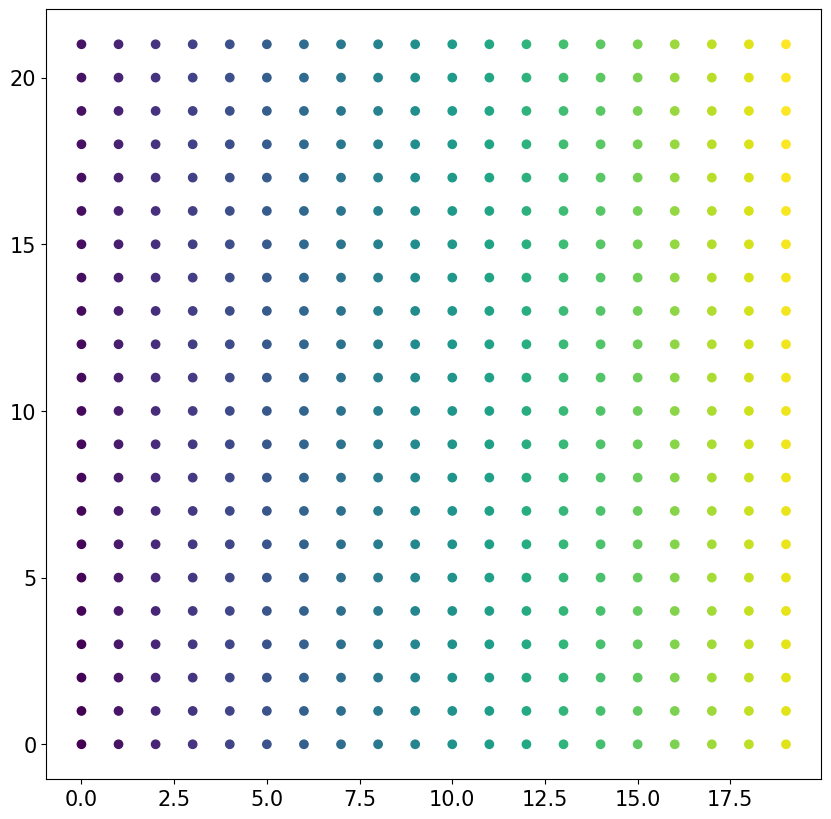

In [9]:
UniqueXs,UniqueYs = IndexToXY(UniquePixelIDs)
plt.figure()
plt.scatter(UniqueXs,UniqueYs,c=UniquePixelIDs)

### Check what the Truth Gen Function Should Be for the Cherenkov Fraction, etc.


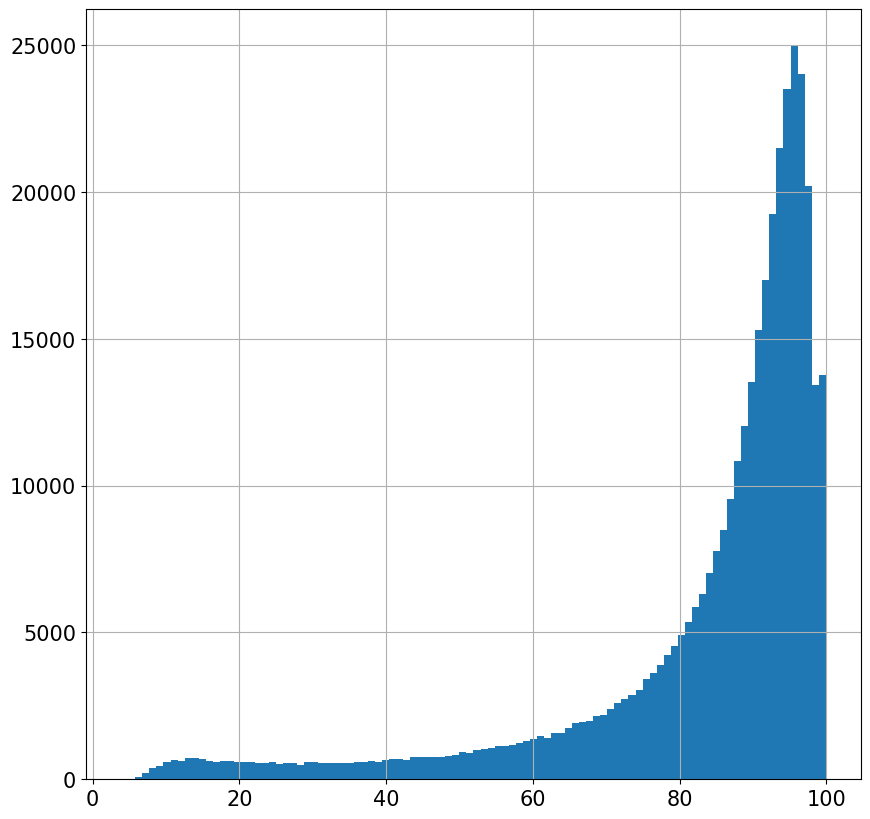

In [10]:
CherenkovFraction = Dataset.get_values('Gen_CherenkovFraction')

plt.figure()
plt.hist(CherenkovFraction,bins=100)
plt.grid()
plt.show()

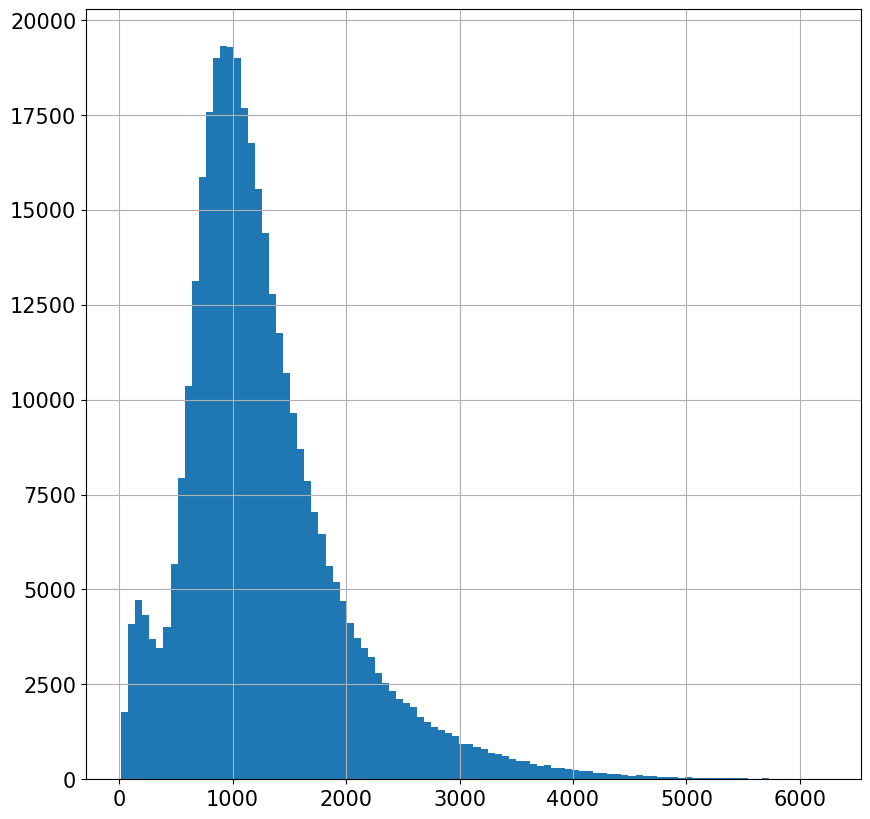

In [11]:
Val = 'Gen_Rp'
X = Dataset.get_values(Val)
                       
plt.figure()
plt.hist(X,bins=100)
plt.grid()

### Constructing Events for cherenkov Fraction
I want to know what the traces length is, check if i can have a good proppa 3d tensor fit thing

In [12]:
Blank_Event = Dataset.get_blank_event()
dir(Blank_Event)

['Event_level_keys',
 'HasTraces',
 'Number_of_pixels',
 'Pixel_level_keys',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_event_data',
 '_pixel_data',
 '_trace_data',
 'add_event_value',
 'add_from_dataset',
 'add_pixel_value',
 'add_trace_values',
 'clean_empty',
 'get_pixel_values',
 'get_trace_values',
 'get_value',
 'next_pixel']

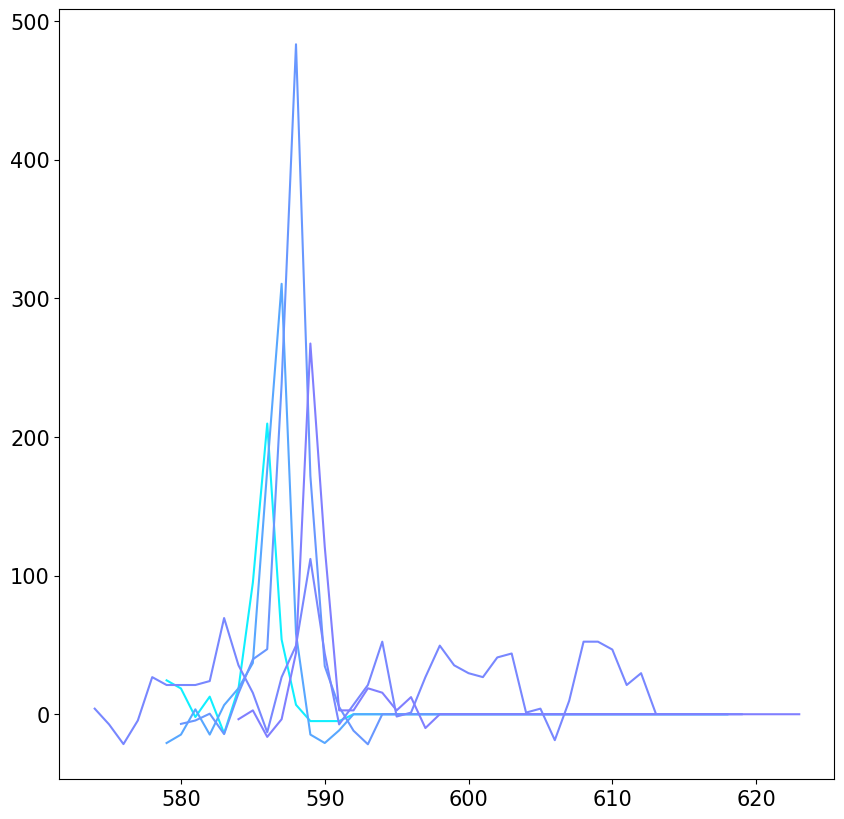

In [54]:
# Select Random Event
EvLength = 999
while EvLength > 40:
    N = np.random.randint(0,len(Dataset))
    Event = Dataset.get_event_by_index(N)
    EvLength = len(Event)


# Get Values
PixelStarts = Event.get_pixel_values('PulseStart')
PixelStatus = Event.get_pixel_values('Status')
PixelPulse   = Event.get_trace_values()


cmap = plt.get_cmap('cool')
plt.figure(figsize = (10,10))
for iPix in range(EvLength):
    # Plot
    plotXs = np.array(range(40))+ PixelStarts[iPix].int().item()
    plotYs = PixelPulse[iPix].numpy()
    
    Color = cmap(iPix/EvLength)
    if PixelStatus[iPix].int().item() ==  4 :
        plt.plot(plotXs,plotYs,color=Color)
    else:
        continue
        plt.plot(plotXs,plotYs,color=Color,linestyle = '--',alpha = 0.5)






In [57]:
All_EventDurations = []

for Event in Dataset:
    try:
        Pixel_PulseStart = Event.get_pixel_values('PulseStart')
        Pixel_PulseStop   = Event.get_pixel_values('PulseStop')
        Puxel_Status     = Event.get_pixel_values('Status')

        Pixel_PulseStart = Pixel_PulseStart[Puxel_Status == 4]
        Pixel_PulseStop   = Pixel_PulseStop[Puxel_Status == 4]
        Min_PulseStart = torch.min(Pixel_PulseStart)
        Max_PulseStop   = torch.max(Pixel_PulseStop)

        EventDuration = Max_PulseStop - Min_PulseStart
        All_EventDurations.append(EventDuration.item())
    except:
        continue


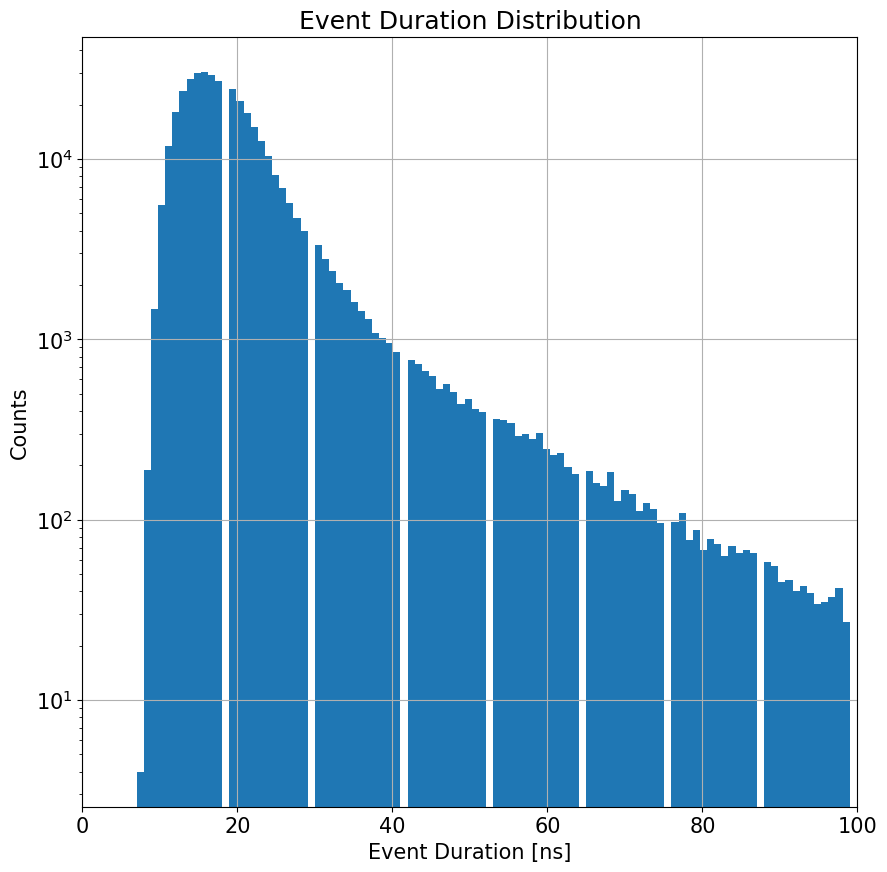

Fraction of Events with Duration >50 bins: 0.03
Fraction of Events with Duration >40 bins: 0.05
Fraction of Events with Duration >30 bins: 0.09
Fraction of Events with Duration >20 bins: 0.33
Fraction of Events with Duration >10 bins: 0.98


In [63]:
All_EventDurations = np.array(All_EventDurations)
plt.figure()
plt.hist(All_EventDurations[All_EventDurations < 100],bins=100)
plt.grid()
plt.xlabel('Event Duration [ns]')
plt.ylabel('Counts')
plt.title('Event Duration Distribution')
plt.yscale('log')
plt.xlim(0,100)
plt.show()

print(f'Fraction of Events with Duration >50 bins: {np.sum(All_EventDurations > 50)/len(All_EventDurations):.2f}')
print(f'Fraction of Events with Duration >40 bins: {np.sum(All_EventDurations > 40)/len(All_EventDurations):.2f}')
print(f'Fraction of Events with Duration >30 bins: {np.sum(All_EventDurations > 30)/len(All_EventDurations):.2f}')
print(f'Fraction of Events with Duration >20 bins: {np.sum(All_EventDurations > 20)/len(All_EventDurations):.2f}')
print(f'Fraction of Events with Duration >10 bins: {np.sum(All_EventDurations > 10)/len(All_EventDurations):.2f}')

### Testing for SDP


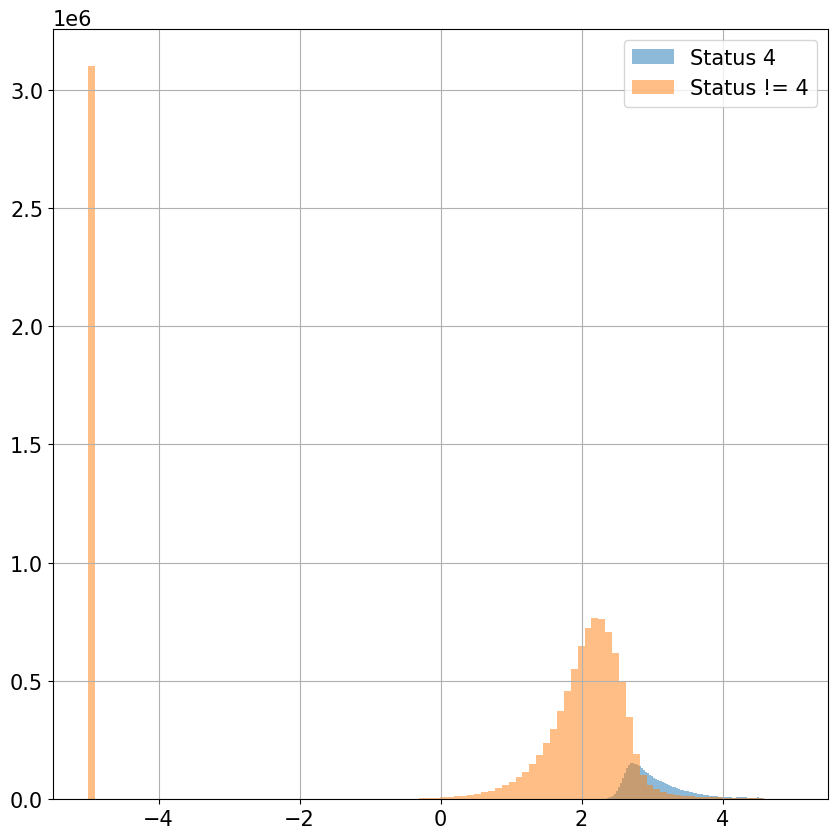

In [17]:
All_Charges = Dataset.get_pixel_values('Charge').numpy()
All_Charges = np.clip(All_Charges,0.00001,np.inf)
All_Charges = np.log10(All_Charges)
All_Status = Dataset.get_pixel_values('Status').numpy()

#  Make a stacked histogram of the charges split for stautus ==4 and !=4
plt.figure()
plt.hist(All_Charges[All_Status == 4],bins=100,alpha=0.5,label='Status 4')
plt.hist(All_Charges[All_Status != 4],bins=100,alpha=0.5,label='Status != 4')
plt.legend()
plt.grid()


For TelID 1.0 the mean is 43.78
For TelID 2.0 the mean is 89.44
For TelID 3.0 the mean is 133.91


<Figure size 1000x1000 with 0 Axes>

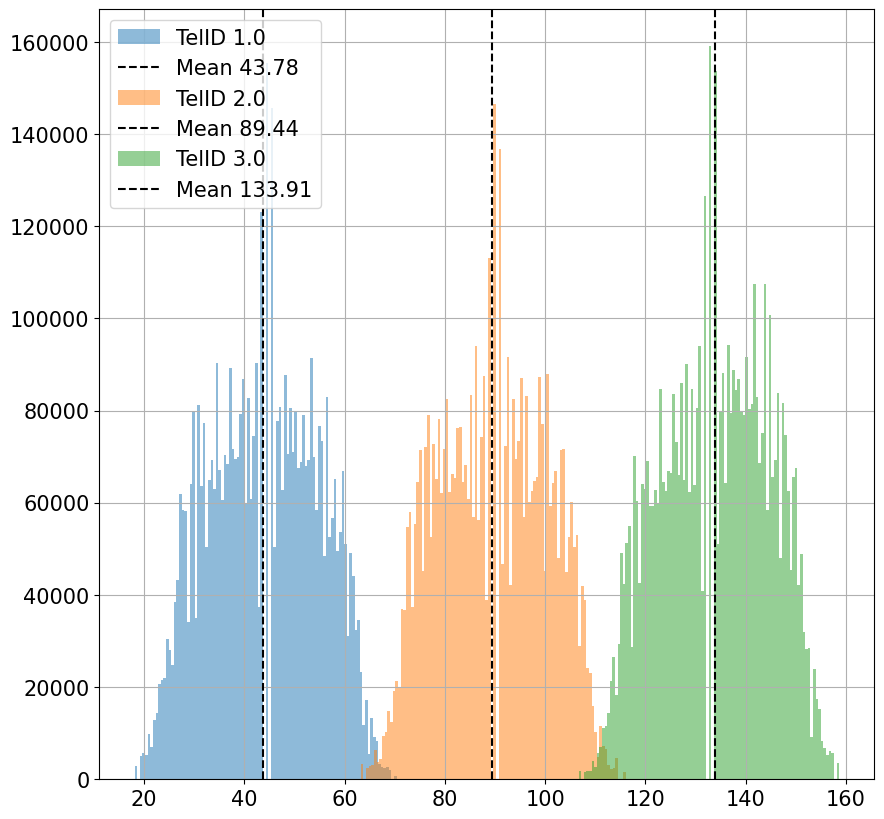

<Figure size 1000x1000 with 0 Axes>

In [20]:
All_Pixel_Phi   = Dataset.get_pixel_values('Phi').numpy()
# All_Pixel_Theta = Dataset.get_pixel_values('Theta').numpy()
All_TelIDs = Dataset.get_pixel_values('TelID').numpy()

plt.figure()
for UniqueTelID in np.unique(All_TelIDs):
    Some_Phi = All_Pixel_Phi[All_TelIDs == UniqueTelID]
    plt.hist(Some_Phi,bins=100,alpha=0.5,label=f'TelID {UniqueTelID}')
    print(f'For TelID {UniqueTelID} the mean is {np.mean(Some_Phi):.2f}')
    plt.axvline(np.mean(Some_Phi),color='k',linestyle='--',label=f'Mean {np.mean(Some_Phi):.2f}')
plt.legend()
plt.grid()
plt.figure()


In [167]:
def Main_Conv2d_Grid_Charge_and_Time(Dataset,ProcessingDataset):
    ''' Will just provide 1 mirror array of pixel signals
    Main is a tensor of shape (N,C,20,22) where C is the number of channels
    Selects only the hottest telescope
    '''
    # Has to be done on Event-by-Event basis
    # Preinitialize the tensor
    IDsList = ()
    Main = torch.zeros((len(Dataset),2,20,22))
    if ProcessingDataset is None:
        Main = torch.zeros(10000,2,20,22)
    for i,Event in enumerate(Dataset):
        if i%100 == 0:
            print(f'    Processing Main {i} / {len(Dataset)}',end='\r')
        if i == 10000 and ProcessingDataset is None: break
        # ID Checks
        ID = (Event.get_value('EventID_1/2').int()*10000 + Event.get_value('EventID_2/2').int()%10000).item()
        IDsList += (ID,)

        # There only should exist only one telescope. So no need to check for telescope selection
        PixelIDs      = Event.get_pixel_values('PixelID')
        TelIDs        = Event.get_pixel_values('TelID')
        Charge        = Event.get_pixel_values('Charge')
        PulseCentroid = Event.get_pixel_values('PulseCentroid')
        PulseCentroid_ZeroMask = PulseCentroid != 0
        # Normalise
        Charge = torch.log10(torch.clamp_min(Charge,0)+1)/3.75
        Time   = PulseCentroid[PulseCentroid_ZeroMask]
        Time = Time - torch.min(Time)
        Time = Time / 40

        Xs,Ys         = IndexToXY(PixelIDs-(TelIDs-1)*440+1, return_tensor=True)
        Main[i,0,Xs,Ys] = Charge

        

        Xs = Xs[PulseCentroid_ZeroMask]
        Ys = Ys[PulseCentroid_ZeroMask]

        Main[i,1,Xs,Ys] = Time

    # Pass the data to the ProcessingDataset
    if ProcessingDataset is None:
        return Main
    ProcessingDataset._Main.append(Main)
    if ProcessingDataset._EventIds is None:
        ProcessingDataset._EventIds = IDsList
    else:
        assert ProcessingDataset._EventIds == IDsList, 'Event IDs do not match'



def Unnormalise_SDP(Truth): 
    # Just for Truth Func below
        Gen_SDPTheta = torch.acos(Truth[:,0])
        Gen_SDPPhi   = torch.asin(Truth[:,1])
        return torch.stack((Gen_SDPTheta,Gen_SDPPhi),dim=1)



def Truth_Just_SDP_single(Dataset,ProcessingDataset):
    '''Gets just the SDP values,
    Does not use atan2 as unnormalisation (<- what single means)
    '''
    IDsList = ()
    Offsets = {1:44.45/180*torch.pi,2:-89.87/180*torch.pi,3:132.83/180*torch.pi}#,4:15/180*torch.pi,5:45/180*torch.pi,6:75/180*torch.pi}

    Gen_SDPTheta = torch.zeros(len(Dataset))
    Gen_SDPPhi   = torch.zeros(len(Dataset))
    Rec_SDPTheta = torch.zeros(len(Dataset))
    Rec_SDPPhi   = torch.zeros(len(Dataset))
    SelectedTelescopes = torch.zeros(len(Dataset))

    if ProcessingDataset is None:
        Gen_SDPTheta = torch.zeros(10000)
        Gen_SDPPhi   = torch.zeros(10000)
        Rec_SDPTheta = torch.zeros(10000)
        Rec_SDPPhi   = torch.zeros(10000)
        SelectedTelescopes = torch.zeros(10000)
    for i,Event in enumerate(Dataset):
        if ProcessingDataset is None and i == 10000: break
        # ID Checks
        ID = (Event.get_value('EventID_1/2').int()*10000 + Event.get_value('EventID_2/2').int()%10000).item()
        IDsList += (ID,)

        if i%100 == 0:
            print(f'    Processing Truth {i} / {len(Dataset)}',end='\r')
        TelIDs        = Event.get_pixel_values('TelID')
        EyeIDs        = Event.get_pixel_values('EyeID')
        SelectedTelescopeID   = TelIDs.int().bincount().argmax()
        
        SelectedTelescopes[i] = SelectedTelescopeID
        Gen_SDPPhi  [i]       = Event.get_value('Gen_SDPPhi')
        Gen_SDPTheta[i]       = Event.get_value('Gen_SDPTheta')
        Rec_SDPPhi  [i]       = Event.get_value('Rec_SDPPhi')
        Rec_SDPTheta[i]       = Event.get_value('Rec_SDPTheta')
    print()

    # Normalise Theta
    Gen_SDPTheta = torch.cos(Gen_SDPTheta)
    Rec_SDPTheta = torch.cos(Rec_SDPTheta)

    # Adjust Phi to be centred around mirror
    Gen_SDPPhi   = Gen_SDPPhi+2*torch.pi*(Gen_SDPPhi<0)
    Gen_SDPPhi   -= torch.pi
    Rec_SDPPhi   = Rec_SDPPhi+2*torch.pi*(Rec_SDPPhi<0)
    Rec_SDPPhi   -= torch.pi
    for i in range(1,4): # Apply offsets
        print(f'Sum of SelectedTelescopes == {i} is {torch.sum(SelectedTelescopes == i)}')
        Gen_SDPPhi[SelectedTelescopes == i] -= Offsets[i]
        Rec_SDPPhi[SelectedTelescopes == i] -= Offsets[i]
    # Normalise Phi
    Gen_SDPPhi   = torch.sin(Gen_SDPPhi)
    Rec_SDPPhi   = torch.sin(Rec_SDPPhi)

    if ProcessingDataset is None:
        return torch.stack((Gen_SDPTheta,Gen_SDPPhi),dim=1), torch.stack((Rec_SDPTheta,Rec_SDPPhi),dim=1)
    ProcessingDataset._Truth = torch.stack((Gen_SDPTheta,Gen_SDPPhi),dim=1)
    ProcessingDataset._Rec   = torch.stack((Rec_SDPTheta,Rec_SDPPhi),dim=1)

    ProcessingDataset.Unnormalise_Truth = Unnormalise_SDP
    ProcessingDataset.Truth_Keys = ('SDPTheta','SDPPhi')
    ProcessingDataset.Truth_Units =('rad','rad')
    if ProcessingDataset._EventIds is None:
        ProcessingDataset._EventIds = IDsList
    else:
        assert ProcessingDataset._EventIds == IDsList, 'Event IDs do not match'



Main = Main_Conv2d_Grid_Charge_and_Time(Dataset,ProcessingDataset=None)
Truth,_ = Truth_Just_SDP_single(Dataset,ProcessingDataset=None)

    Processing Truth 9900 / 375911
Sum of SelectedTelescopes == 1 is 3091
Sum of SelectedTelescopes == 2 is 3270
Sum of SelectedTelescopes == 3 is 3639


Gen_SDPTheta: 109.64120184027948
Gen_SDPPhi: 52.5748688719854


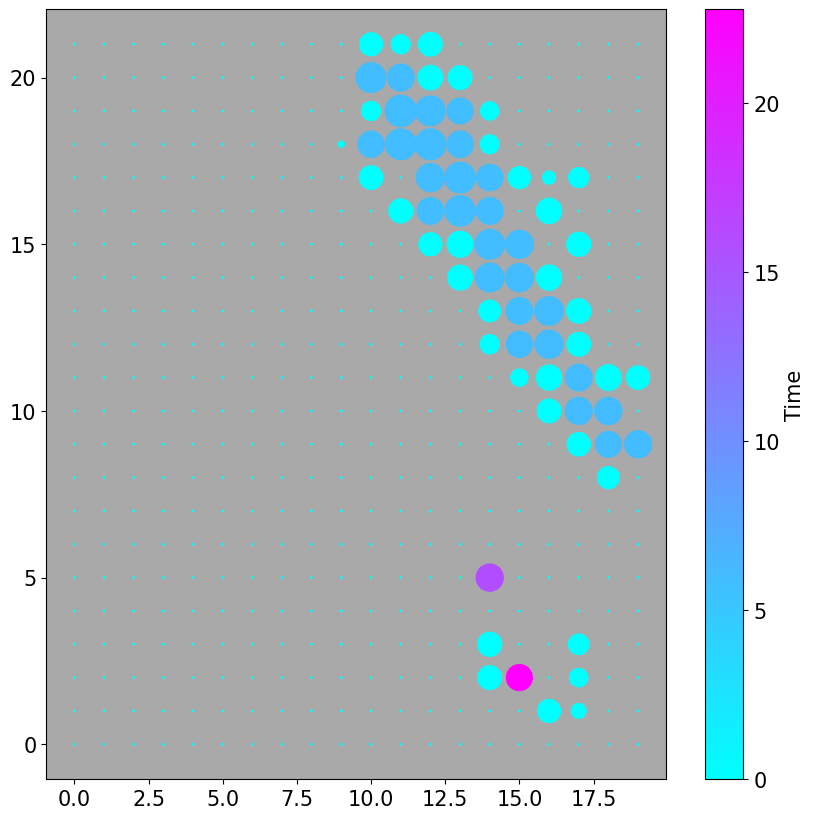

In [213]:
# N = np.random.randint(0,Main.shape[0])

plt.figure()
# plt.imshow(Main[N,0],cmap='cool',vmin=0,vmax=1)
# Instead of imshow, produce a scatter
Xs,Ys = IndexToXY(torch.arange(440)+1)
plt.scatter(Xs,Ys,c=Main[N,1].flatten().numpy(),cmap='cool',s = 500*Main[N,0].flatten().numpy()+1)
plt.colorbar(label='Time')
#  set facecolor to dark grey
plt.gca().set_facecolor('darkgrey')
# plt.gca().invert_yaxis()
ThisTruth = Unnormalise_SDP(Truth[N].unsqueeze(0))
# ThisTruth = Truth[N].unsqueeze(0)
Gen_SDPTheta = ThisTruth[0,0].item()
Gen_SDPPhi   = ThisTruth[0,1].item()


print('Gen_SDPTheta:',Gen_SDPTheta/np.pi*180)
print('Gen_SDPPhi:',Gen_SDPPhi/np.pi*180)


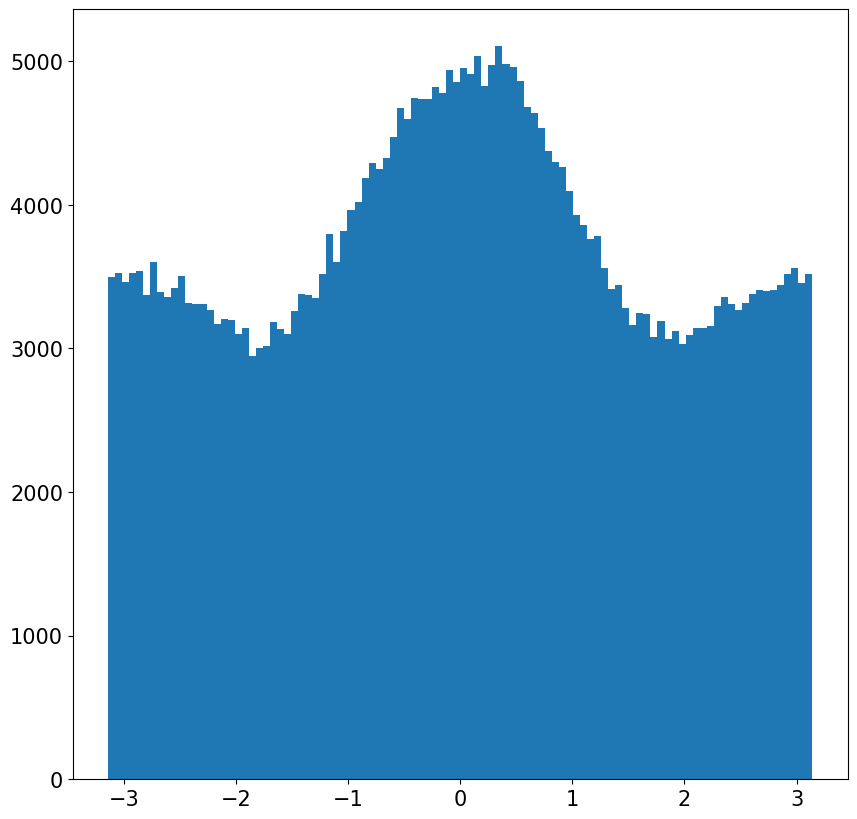

In [124]:
All_SDPPhi = Dataset.get_values('Gen_SDPPhi').numpy()
All_SDPPhi = All_SDPPhi+2*np.pi*(All_SDPPhi<0)
All_SDPPhi -= np.pi
plt.figure()
plt.hist(All_SDPPhi,bins=100)
plt.show()

(array([4954., 4918., 5033., 4829., 4971., 5103., 4988., 4961., 4857.,
        4685., 4639., 4528., 4375., 4301., 4265., 4095., 3931., 3858.,
        3764., 3780., 3563., 3407., 3440., 3283., 3162., 3242., 3243.,
        3075., 3192., 3066., 3120., 3032., 3090., 3144., 3143., 3155.,
        3294., 3360., 3306., 3266., 3317., 3378., 3406., 3401., 3406.,
        3444., 3517., 3561., 3455., 3521., 3494., 3521., 3465., 3523.,
        3538., 3374., 3601., 3394., 3351., 3422., 3506., 3319., 3308.,
        3311., 3258., 3174., 3213., 3190., 3097., 3146., 2946., 3010.,
        3015., 3183., 3135., 3100., 3258., 3377., 3371., 3355., 3522.,
        3794., 3607., 3814., 3964., 4016., 4185., 4294., 4250., 4332.,
        4473., 4678., 4599., 4744., 4740., 4729., 4823., 4777., 4939.,
        4852.]),
 array([-3.14159012e+00, -3.07875848e+00, -3.01592684e+00, -2.95309520e+00,
        -2.89026380e+00, -2.82743216e+00, -2.76460052e+00, -2.70176888e+00,
        -2.63893723e+00, -2.57610559e+00, -2.51327

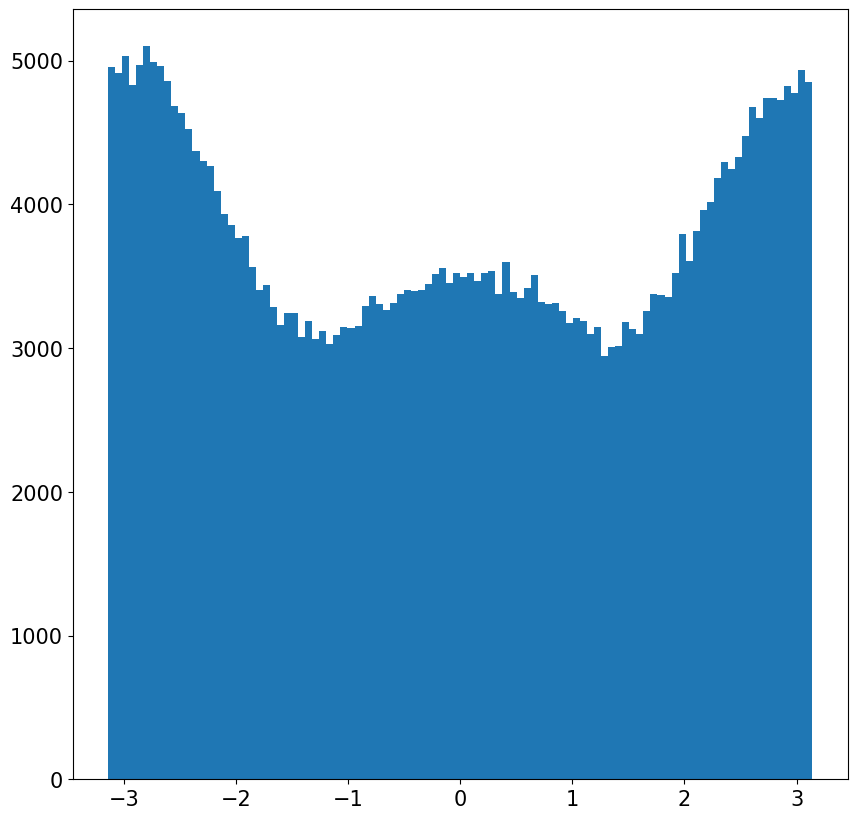

In [212]:
All_SDP_PHI = Dataset.get_values('Gen_SDPPhi').numpy()
plt.figure()
plt.hist(All_SDP_PHI,bins=100)

In [158]:
All_PulseCentroid = []
All_Status        = []

for i, Event in enumerate(Dataset):
    if i%10000 == 0: print(f'    Processing PulseCentroid {i} / {len(Dataset)}')
    These_PulseCentroids = Event.get_pixel_values('PulseCentroid')
    These_Statuses       = Event.get_pixel_values('Status')
    if torch.sum(These_Statuses == 4) == 0:continue

    The_Min_PulseCentroid = torch.min(These_PulseCentroids)
    These_PulseCentroids -= The_Min_PulseCentroid

    All_PulseCentroid.append(These_PulseCentroids)
    All_Status.append(These_Statuses)

All_PulseCentroid = torch.cat(All_PulseCentroid).numpy()
All_Status        = torch.cat(All_Status).numpy()

    Processing PulseCentroid 0 / 375911
    Processing PulseCentroid 10000 / 375911
    Processing PulseCentroid 20000 / 375911
    Processing PulseCentroid 30000 / 375911
    Processing PulseCentroid 40000 / 375911
    Processing PulseCentroid 50000 / 375911
    Processing PulseCentroid 60000 / 375911
    Processing PulseCentroid 70000 / 375911
    Processing PulseCentroid 80000 / 375911
    Processing PulseCentroid 90000 / 375911
    Processing PulseCentroid 100000 / 375911
    Processing PulseCentroid 110000 / 375911
    Processing PulseCentroid 120000 / 375911
    Processing PulseCentroid 130000 / 375911
    Processing PulseCentroid 140000 / 375911
    Processing PulseCentroid 150000 / 375911
    Processing PulseCentroid 160000 / 375911
    Processing PulseCentroid 170000 / 375911
    Processing PulseCentroid 180000 / 375911
    Processing PulseCentroid 190000 / 375911
    Processing PulseCentroid 200000 / 375911
    Processing PulseCentroid 210000 / 375911
    Processing PulseCent

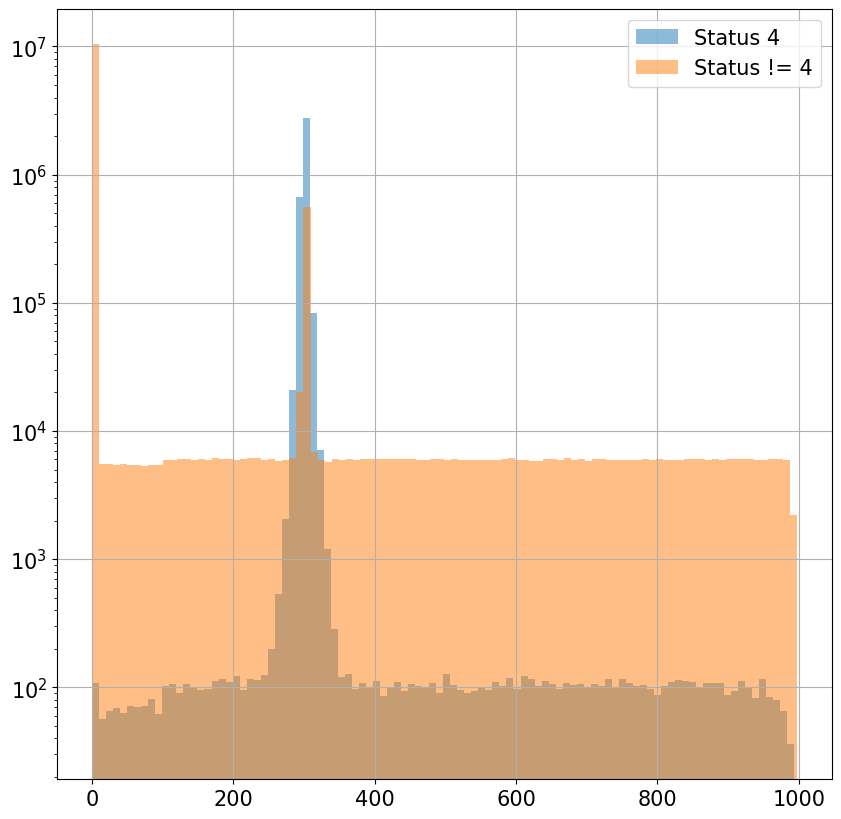

In [160]:
plt.figure()
plt.hist(All_PulseCentroid[All_Status == 4],bins=100,alpha=0.5,label='Status 4')
plt.hist(All_PulseCentroid[All_Status != 4],bins=100,alpha=0.5,label='Status != 4')
plt.grid()
plt.yscale('log')
plt.legend()


In [156]:
All_Status = Dataset.get_pixel_values('Status').numpy()
print(f'All Status == 4:',np.sum(All_Status == 4))
print(f'All Status != 4:',np.sum(All_Status != 4))

print(f'Ratio of Status !=4 vs Status == 4:',np.sum(All_Status != 4)/np.sum(All_Status == 4))


All Status == 4: 3569753
All Status != 4: 11569743
Ratio of Status !=4 vs Status == 4: 3.241048610366039


### End?